In [310]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
from src.source_selector import Recommender, InfluenceModel, EdgeSplitter, PaperNLP
from src.graphing import AuthorNetwork
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score, roc_curve, log_loss
from sklearn.model_selection import train_test_split
from src.component import ComponentCreator
from src.to_gexf import pd_to_gexf

import matplotlib.pyplot as plt
import requests
import json
import random

In [ ]:
client = MongoClient()
papers = client.capstone.papers

In [ ]:
comp_creator = ComponentCreator(collection=papers)
E,X = comp_creator.edge_construct(['1c2a234329c161bd187b61cb9794d68b03dd1296',
                                    '00242e2b73910516973c9647c93f12de3ffb35f9'], 4,
                                 lim=10000)
E_,X_ = comp_creator.mixed_construct(4100442, lim=10000)

In [ ]:
E,X = comp_creator.edge_construct(lim=10000)
E_,X_ = comp_creator.mixed_construct(lim=10000)

In [354]:
_E, _X = comp_creator.mixed_construct(4100442)

In [143]:
_recommender = Recommender(GradientBoostingClassifier(), 'paperAbstract', 'title','entities')

In [144]:
_recommender.fit(_X)

In [56]:
recommender = Recommender(GradientBoostingClassifier(), 'paperAbstract', 'title','entities')
recommender_ = Recommender(GradientBoostingClassifier(), 'paperAbstract', 'title','entities')

In [57]:
splitter = EdgeSplitter()
X0, Xt, E0, Et = splitter.split(X, E)
X0_,Xt_,E0_,Et_ = splitter.split(X_, E_)
y0, yt = E0['edge'], Et['edge']
y0_, yt_ = E0_['edge'], Et_['edge']

In [58]:
recommender.fit(X0)
recommender_.fit(X0_)

In [60]:
tpr, fpr, thr = roc_curve(y_score=recommender.predict_proba(Et, Xt),
                          y_true=yt.astype(int))
tpr_, fpr_, thr_ = roc_curve(y_score=recommender_.predict_proba(Et_, Xt_),
                          y_true=yt_.astype(int))



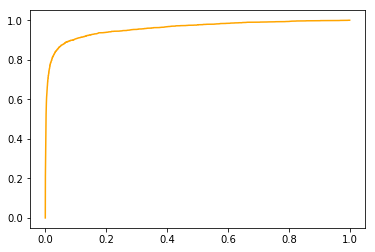

In [95]:

plt.plot(tpr_,fpr_, color='orange')

In [97]:
roc_auc_score(y_score=recommender_.predict_proba(Et_, Xt_), y_true=yt_.astype(int))

0.9592921019266056

In [99]:
roc_auc_score(y_score=recommender.predict_proba(Et, Xt), y_true=yt.astype(int))

0.931590126633868

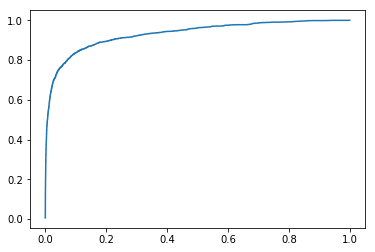

In [98]:
plt.plot(tpr,fpr)
# plt.plot(tpr_,fpr_, color='orange')

In [92]:
edges, edges_ = E, E_
nodes, nodes_ = X, X_

In [90]:
edges, edges_ = E[E['edge']==1], E_[E_['edge']==1]
nodes, nodes_ = Xt, Xt_

In [94]:
edges['weight'] = recommender.predict_proba(edges, nodes)
edges['id'] = edges.index
nodes['id'] = nodes['_id']

In [85]:
edges_['weight'] = recommender_.predict_proba(edges_, nodes_)
edges_['id'] = edges_.index
nodes_['id'] = nodes_['_id']

/Users/alexklein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/alexklein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/alexklein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [84]:
pd_to_gexf(edges, nodes, 'example.gexf', node_attr={'year':'float'}, edge_attr={'weight':'float'})

In [86]:
pd_to_gexf(edges_, nodes_, 'example_.gexf', node_attr={'year':'float'}, edge_attr={'weight':'float'})

In [ ]:
recommeder = Recommender(GradientBoostingClassifier(), 'paperAbstract', 'title','entities')

In [ ]:
fields = ['paperAbstract','title','entities']
nlp = PaperNLP(*fields)
splitter = EdgeSplitter()
X0,Xt,E0,Et = splitter.split(X, E)
nlp.fit(X0)
S0,St = [nlp.similarity_matrix(X) for X in (X0,Xt)]
y0,yt = E0['edge'], Et['edge']
for field in fields:
    E0[field + '_similarity'] = S0[field].lookup(col_labels=E0['src'], row_labels=E0['dst'])
    Et[field + '_similarity'] = St[field].lookup(col_labels=Et['src'], row_labels=Et['dst'])

In [ ]:
E0['age'] = abs(X0['year'][E0['dst']].values - X0['year'][E0['src']].values)
Et['age'] = abs(Xt['year'][Et['dst']].values - Xt['year'][Et['src']].values)

E0['age'] = np.where(E0['age'].isnull(), 0, E0['age'])
Et['age'] = np.where(Et['age'].isnull(), 0, Et['age'])

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=5000)
gbc.fit(E0.drop(columns=['src','dst','edge'], axis=1), y0.astype(int).values.reshape(-1,1))
tpr, fpr, thr = roc_curve(y_score=gbc.predict_proba(
    Et.drop(columns=['src','dst','edge']))[:,1], 
                          y_true=yt.astype(int))
print(roc_auc_score(y_score=gbc.predict_proba(
    Et.drop(columns=['src','dst','edge']))[:,1],
      y_true=yt.astype(int)))
plt.plot(tpr,fpr)


In [ ]:
Et[Et['edge'] == 1]

In [ ]:
recommeder = Recommender(GradientBoostingClassifier(), 'paperAbstract', 'title','entities')

In [ ]:
recommeder.fit(X0)

In [ ]:
recommeder.predict_one(x,y)

In [ ]:
resp=requests.get('http://api.semanticscholar.org/v1/paper/0796f6cd7f0403a854d67d525e9b32af3b277331')
pd.DataFrame(resp.json()['references'])

In [ ]:
%pdb
recommeder.predict(x=pd.DataFrame([{'_id':'test', 'paperAbstract':sample_abstract, 
                                    'title':sample_title, 
                                    'entities':[]}]))

# Authors
    ID: author id 
    Papers: list of paper ids
    In: list of citing author ids
    Out: list of cited author ids
    Peers: list of all coauthor ids
    
# Papers
    ID: paper id
    Authors: list of author ids
    In: list of in citations
    Out: list of out citations
    Peers: list of papers ids with shared authors
    Influenced: list of highly influenced paper ids
    Influential: list of highly influential paper ids

In [2]:
import networkx as nx
def cosimrank(S, A, C=1e-5):
    A/= np.sqrt((A * A).sum(axis=1))
    A = np.where(np.isfinite(A), A, 0)
    return C*(A.T @ S @ A) + np.identity(A.shape[0])

def simrank(S, A, C=1e-5):
    return (cosimrank(S,A,C) - np.identity(A.shape[0])).max(axis=1)

def adj_matrix(edges, nodelist=None):
    g = nx.Graph(edges)
    return nx.adj_matrix(g, nodelist=nodelist)

def sim_matrix(nodes, mdl):
    return mdl.similarity_matrix(nodes)

def power_iteration(X, n):
    v = unit_vect(X.shape[1])
    for _ in range(n):
        v_ = X @ v
        v = v_ / np.linalg.norm(v)
    return v

def cosim(n, m, S, A, C=1e-5, k=100, nodelist=None):
    A/= np.sqrt((A * A).sum(axis=1))
    A = np.where(np.isfinite(A), A, 0)
    p_ = p(n, A.shape[1])
    sim = 0
    for k_ in range(k):
        sim += C**k_ * p_[m] * p_[n]
        p_ = A @ p_
    return sim

def p(i, n):
    return np.where(np.arange(n) == i, 1, 0)


In [ ]:
recommeder.predict_one(X.loc['d66324821e45348d7173a790902fe37a1fe0c4f9'],
                       X.loc['6e727df3e527706f79f95621218d9c836b8cdf66'])


In [ ]:
adj = adj_matrix(E.values.tolist(), X['_id'])
sim = sim_matrix(X, nlp)['paperAbstract']

In [ ]:
cosim(765, 897, sim, adj, 1)

In [ ]:
simrank(sim, adj)

In [ ]:
cosimrank(sim, adj, 1)[765,897]

In [ ]:
cosimrank(sim, adj)[cosimrank(sim, adj) != 1].argmax()%adj.shape[1]

In [ ]:
adj / (np.ones(adj.shape) * np.sqrt(sum(adj * adj)).toarray())

In [ ]:
adj_ = adj / np.sqrt((adj * adj).sum(axis=1))
adj_ = np.where(np.isfinite(adj_), adj_, 0)

In [ ]:
np.linalg.norm?

In [ ]:
sample_abstract = '''In this paper we address the problem of classifying cited work into important and non-important to the developments presented in a research publication. This task is vital for the algorithmic techniques that detect and follow emerging research topics and to qualitatively measure the impact of publications in increasingly growing scholarly big data. We consider cited work as important to a publication if that work is used or extended in some way. If a reference is cited as background work or for the purpose of comparing results, the cited work is considered to be non-important. By employing five classification techniques (Support Vector Machine, Naïve Bayes, Decision Tree, K-Nearest Neighbors and Random Forest) on an annotated dataset of 465 citations, we explore the effectiveness of eight previously published features and six novel features (including context based, cue words based and textual based). Within this set, our new features are among the best performing. Using the Random Forest classifier we achieve an overall classification accuracy of 0.91 AUC'''


# '''BACKGROUND
# The primary determinant of reproductive age in women is the number of ovarian non-growing (primordial, intermediate and primary) follicles (NGFs). To better characterize the decline in NGF number associated with aging, we have employed modern stereology techniques to determine NGF number in women from birth to menopause.


# METHODS
# Normal human ovaries were collected from 122 women (aged 0-51 years) undergoing elective oophorectomy, organ donation or autopsy. After gross pathologic examination, systematic random sampling was utilized to obtain tissue for analysis by the fractionator/optical disector method. Models to describe the resulting decay curve were constructed and evaluated.


# RESULTS
# NGF decay was best described by a simple power function: log (y) = ax(b) + c, where a, b and c are constants and y = NGF count at age x (R(2) = 0.84, Sums of Squares Error = 28.18 on 119 degrees of freedom). This model implies that follicles decay faster with increasing age.


# CONCLUSIONS
# Unlike previous models of ovarian follicle depletion, our model predicts no sudden change in decay rate, but rather a constantly increasing rate. The model not only agrees well with observed ages of menopause in women, but also is more biologically plausible than previous models. Although the model represents a significant improvement compared with earlier attempts, a considerable percentage of the variation in NGF number between women cannot be explained by age alone.'''

sample_title = '''Identifying Important Citations Using Contextual Information from Full Text'''
#'''A new model of reproductive aging: the decline in ovarian non-growing follicle number from birth to menopause.'''



In [ ]:
x = X2.paper_nodes[X2.paper_nodes['_id'] == '02a698470f476de722e78b20d0ddd92d3781bbfc']
y = X2.paper_nodes[X2.paper_nodes['_id'] == 'e95b97b143378e91acaf5b6e9110dbd5b1c4ed22']


In [ ]:
InfluenceModel(base=GradientBoostingClassifier())
x,y = InfluenceModel.generate_edge_ids('e95b97b143378e91acaf5b6e9110dbd5b1c4ed22')

In [ ]:
recommeder = Recommender(GradientBoostingClassifier(), 'paperAbstract', 'title','entities')
recommeder.fit(X)

In [ ]:
E[E['src'] == '51b64144ea8026984333b038aec9679d4a41c1a8']

In [ ]:
lookup_id = '51b64144ea8026984333b038aec9679d4a41c1a8'
x = pd.DataFrame(X.loc[lookup_id]).T
for i, _id in enumerate(recommeder.predict(x, 1000)['_id'].values):
    isInCitation = _id in x['inCitations'].values[0]
    isOutCitation = _id in x['outCitations'].values[0]
    if isInCitation or isOutCitation: 
        isInfluential = y[(E['dst']==_id) & (E['src']==lookup_id)] \
                        if isInCitation else \
                        y[(E['src']==_id) & (E['dst']==lookup_id)]
        print(f'Found Citaition at: {i}')
#         print(f'    Is influential: {isInfluential}')


In [ ]:
comp_creator = ComponentCreator(collection=papers)
E,X,Y = comp_creator.edge_construct(['e95b97b143378e91acaf5b6e9110dbd5b1c4ed22'],4)

In [ ]:
X.index = X['_id']

In [ ]:
e = recommeder._transform_edges(E,X).drop(['src','dst'],axis=1)

In [ ]:
mdl = RandomForestClassifier(max_depth=5, criterion='entropy', n_estimators=5000, n_jobs=-1, max_features=2)
# mdl = GradientBoostingClassifier(n_estimators=10000, learning_rate=0.1, max_features='sqrt')
e0,et,y0,yt = train_test_split(e,y)
mdl.fit(e0,y0)

In [ ]:
try:
    tpr, fpr, thr = roc_curve(y_score=mdl.predict_proba(et)[:,1], y_true=yt)
    
    print(roc_auc_score(y_score=mdl.predict_proba(et)[:,1], y_true=yt))
    print(log_loss(y_pred=mdl.predict_proba(et), y_true=yt))
    plt.plot(tpr,fpr)
except AttributeError:
    tpr, fpr, thr = roc_curve(y_score=mdl.predict(et), y_true=yt)
    print(roc_auc_score(y_score=mdl.predict(et), y_true=yt))
    print(log_loss(y_pred=mdl.predict(et), y_true=yt))
    plt.plot(tpr,fpr)

------








 






-----

# Example

In [149]:
title = '''
The Design and Analysis of Computer Algorithms
'''

abstract = '''
Addison-Wesley Pub. Co., 1974, , 470 pages. With this text, you gain an understanding of the fundamental concepts of algorithms, 
the very heart of computer science. It introduces the basic data structures and programming techniques often used in efficient 
algorithms. Covers use of lists, push-down stacks, queues, trees, and graphs. Later chapters go into sorting, 
searching and graphing algorithms, the string-matching algorithms, and the Schonhage-Strassen 
integer-multiplication algorithm. Provides numerous graded exercises at the end of each chapter. 
'''

tags = [
    'stacks', 
    'queues', 
    'trees',
    'algorithm',
    'computer science',
    'data science'
]

In [150]:
x = pd.DataFrame([
    {'_id':'test', 
     'paperAbstract': abstract, 
     'title':title, 
     'entities':tags,
     'year':2018}
])

In [153]:
# print('\n\n'.join(_recommender.recommend(x, 25)['title'].values))

Computer Model of Gambling and Bluffing

Benchmarking graph-based clustering algorithms

A hybrid genetically-bacterial foraging algorithm converged by particle swarm optimisation for global optimisation

Performance assessment of foraging algorithms vs. evolutionary algorithms

Combining Pattern Classifiers: Methods and Algorithms

Computer Poker

A New Heuristic Algorithm for Unit Commitment Problem

Computer Models of Stroke Recovery: Implications for Neurorehabilitation

Low-Complexity MAP-Based Successive Data Detection for Coded OFDM Systems Over Highly Mobile Wireless Channels

A two-stage framework for bat algorithm

Secure Computer Systems: A Retrospective

ChucK: A Strongly Timed Computer Music Language

The fifth generation - artificial intelligence and Japan's computer challenge to the world

A Novel Evolutionary-Fuzzy System for Function Approximation and Comparison the Robust of Used Evolutionary Algorithms

Rounding-o errors in matrix processes

AM Turing ’ s Original Pr